In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("Current device is mps")

Current device is mps


## Import Datasets

In [3]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5, ))])

# ensure a signgle channel of (1, 32, 32)

In [4]:
train_dataset = datasets.CIFAR10(root = "./data/cifar10", train = True, download = True, transform=transform)
test_dataset = datasets.CIFAR10(root = "./data/cifar10", train = False, download = False, transform=transform)

100%|██████████| 170498071/170498071 [00:59<00:00, 2847011.86it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle = False)

In [6]:
print(len(train_loader))
print(len(test_loader))

500
100


In [7]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    # convert to numpy array
    image = image.transpose(1, 2, 0)
    # to plot the image, the shape need to be 28, 28, 1
    # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image
    

In [8]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

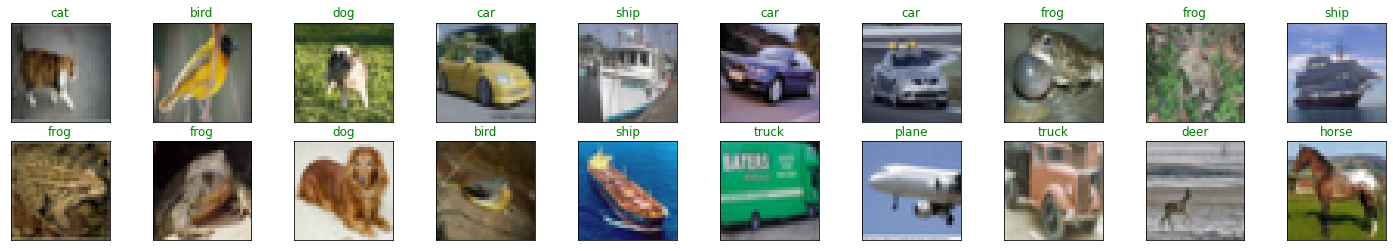

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()], color = "green")

## Build CNN model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels = 20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features = 5 * 5 * 50, out_features = 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # 32 * 32
        x = F.relu(self.conv1(x)) 
        # 28 * 28
        x = F.max_pool2d(x, 2, 2)
        # 14 * 14
        x = F.relu(self.conv2(x))
        # 10 * 10
        x = F.max_pool2d(x, 2, 2)
        # 5 * 5
        
        x = x.view(-1, 5*5*50) #flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Model Training

In [11]:
def train_model(model, epochs = 15, learning_rate = 0.0001, loss = "CrossEntropy", optimizer = "Adam"):
    if loss == "CrossEntropy":
        criterion = nn.CrossEntropyLoss()
    
    if optimizer == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.7)
    elif optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    ########################################################################
    train_loss_history = []
    train_acc_history = []
    
    test_loss_history = []
    test_acc_history = []
    ########################################################################
    
    for e in range(epochs):
        
        print("Current epoch: {}".format(e + 1))
        
        train_loss = 0.0
        train_acc = 0.0
        
        test_loss = 0.0
        test_acc = 0.0
        
        for inputs, labels in train_loader:
            
            inputs = inputs.to(mps_device)
            labels = labels.to(mps_device)
            
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            train_loss += loss.item()
            train_acc += torch.sum(preds == labels.data)
        
        ########################################################################
        else:
            
            with torch.no_grad():
                for test_inputs, test_labels in test_loader:

                    test_inputs = test_inputs.to(mps_device)
                    test_labels = test_labels.to(mps_device)
                    
                    
                    test_outputs = model(test_inputs)
                    test_loss = criterion(test_outputs, test_labels)
                    
                    _, test_preds = torch.max(test_outputs, 1)
                    test_loss += test_loss.item()
                    test_acc += torch.sum(test_preds == test_labels.data)
                    
        ########################################################################
        epoch_loss = train_loss / len(train_loader)
        epoch_acc = train_acc.float() / len(train_loader)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())
        
        test_epoch_loss = test_loss / len(test_loader)
        test_epoch_acc = test_acc / len(test_loader)
        test_loss_history.append(test_epoch_loss.cpu().item())
        test_acc_history.append(test_epoch_acc.item())
        
        print("Training loss: {}, accuracy: {}".format(epoch_loss, epoch_acc))
        print("Testing loss: {}, accuracy: {}".format(test_epoch_loss, test_epoch_acc))      

    return {"train_loss": train_loss_history, "train_acc" : train_acc_history, "test_loss" : test_loss_history, "test_acc" : test_acc_history}

In [12]:
base_line_model = CNN().to(mps_device)

In [13]:
base_line_history = train_model(base_line_model)

Current epoch: 1
Training loss: 1.788973158121109, accuracy: 35.93800354003906
Testing loss: 0.029890289530158043, accuracy: 44.39999771118164
Current epoch: 2
Training loss: 1.476229320526123, accuracy: 47.034000396728516
Testing loss: 0.027859684079885483, accuracy: 49.75
Current epoch: 3
Training loss: 1.3720383193492889, accuracy: 51.202003479003906
Testing loss: 0.02693990245461464, accuracy: 52.05999755859375
Current epoch: 4
Training loss: 1.3009036831855774, accuracy: 54.112003326416016
Testing loss: 0.02530735731124878, accuracy: 55.07999801635742
Current epoch: 5
Training loss: 1.2428714421987535, accuracy: 56.070003509521484
Testing loss: 0.024853643029928207, accuracy: 56.43000030517578
Current epoch: 6
Training loss: 1.1902416157722473, accuracy: 57.87400436401367
Testing loss: 0.023417791351675987, accuracy: 58.39999771118164
Current epoch: 7
Training loss: 1.1449662562608718, accuracy: 59.8280029296875
Testing loss: 0.02482062578201294, accuracy: 58.39999771118164
Curren

## Compare Results

In [14]:
def plot_history(history):
    plt.figure(figsize=(10, 8))
    plt.plot(history["train_loss"], label = "Training loss")
    plt.plot([i/100 for i in history["train_acc"]], label = "Training acc")

    plt.plot(history["test_loss"], label = "Testing loss")
    plt.plot([i / 100 for i in history["test_acc"]], label = "Testing acc")
    plt.plot(np.ones(len(history["train_acc"])), linestyle = "dashed")

    plt.xlabel("Epochs")
    plt.title("Model Training History")
    plt.legend()
    plt.show()

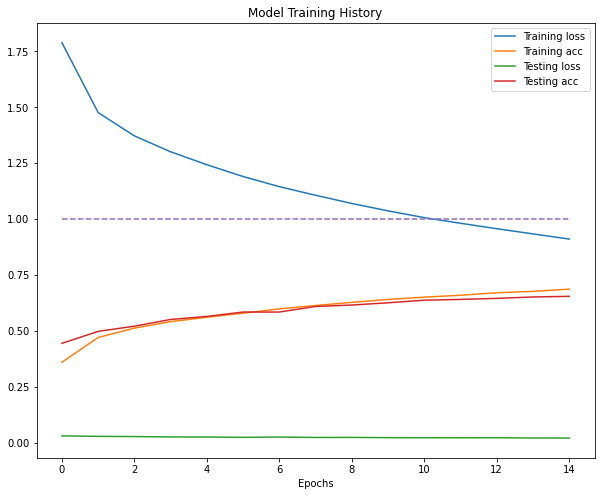

In [15]:
plot_history(base_line_history)

In [16]:
from urllib import response
import PIL.ImageOps
import requests
from PIL import Image

def predict_img(model, url):
    response = requests.get(url, stream = True)
    img = Image.open(response.raw)
    plt.imshow(img)
    
    img = transform(img)
    image = img.to(mps_device)
    output = model(image)
    _, pred = torch.max(output, 1)
    plt.title("Model Prediction is: {}".format(classes[pred.item()]))

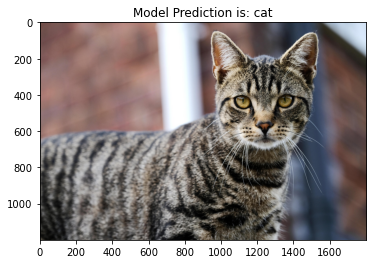

In [17]:
predict_img(base_line_model, "https://static01.nyt.com/images/2021/09/14/science/07CAT-STRIPES/07CAT-STRIPES-mobileMasterAt3x.jpg")

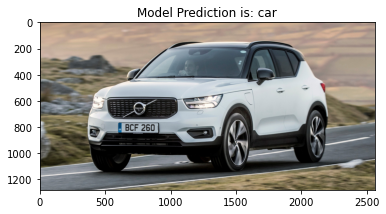

In [18]:
predict_img(base_line_model, "https://carwow-uk-wp-3.imgix.net/Volvo-XC40-white-scaled.jpg")

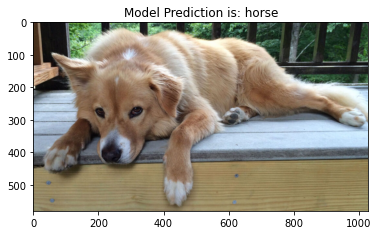

In [19]:
predict_img(base_line_model, "https://www.sciencenews.org/wp-content/uploads/2022/04/042822_AG_dog-breeds_feats-1030x580.jpg")

In [20]:
def plot_predictions(model):
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.to(mps_device)
    labels = labels.to(mps_device)
    output = model(images)
    _, preds = torch.max(output, 1)

    fig = plt.figure(figsize=(40, 10))

    for i in np.arange(20):
        ax = fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
        plt.imshow(im_convert(images[i]))
        ax.set_title("Prediction: {} , True label: {}".format(classes[preds[i].item()], classes[labels[i].item()]), color = ("green" if preds[i] == labels[i] else "red"))

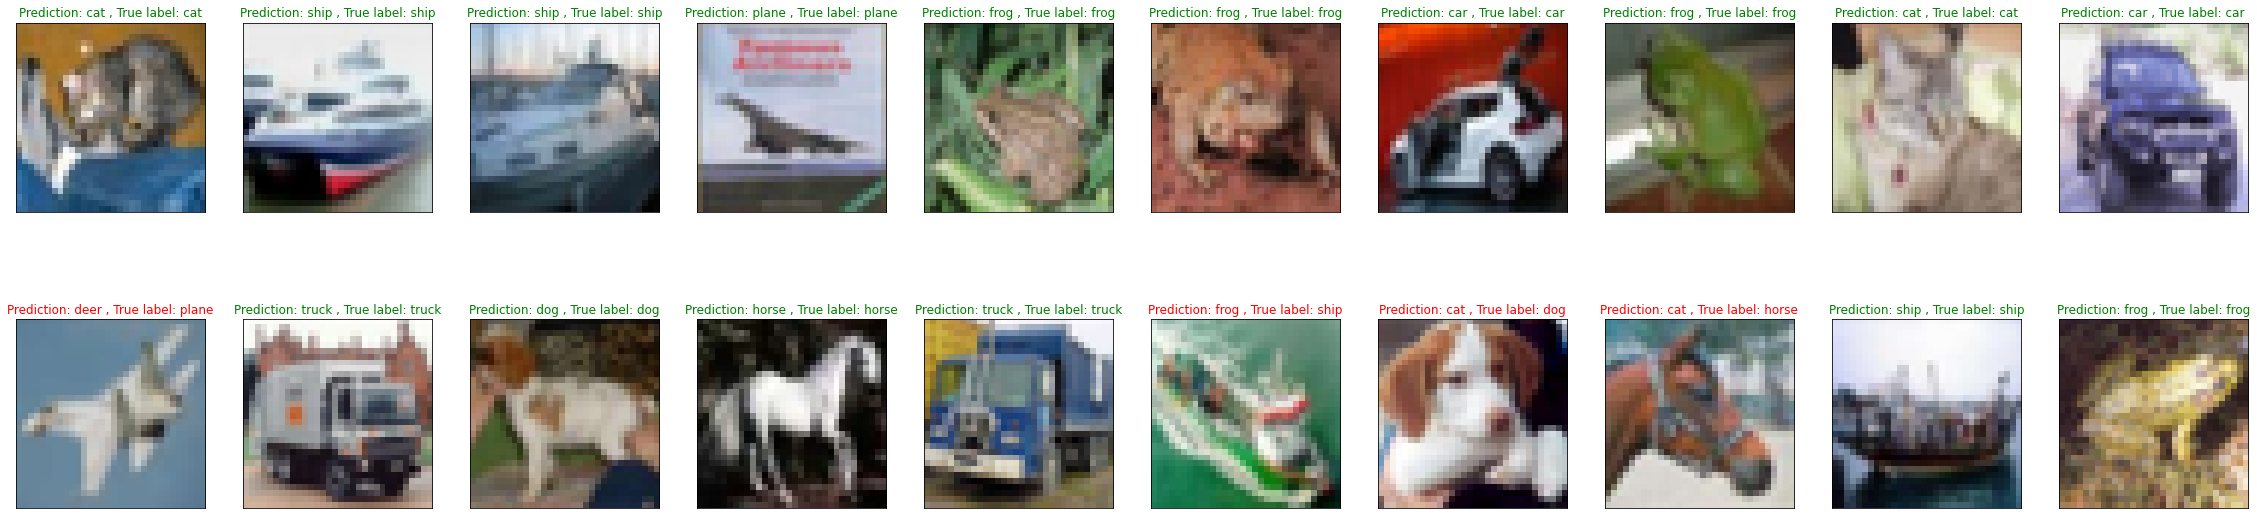

In [21]:
plot_predictions(base_line_model)

In [22]:
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix

# def plot_classification_result(model):
#     test_outputs = model(X_test)
#     _, test_preds = torch.max(test_outputs, 1)
    
#     classes_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]
#     print(classification_report(y_test.numpy(), test_preds.numpy(), target_names=classes_names))
    
#     cm = confusion_matrix(y_test.numpy(), test_preds.numpy())
#     cm = pd.DataFrame(cm, index = classes_names, columns = classes_names)
    
#     plt.figure(figsize = (15, 15))
#     sns.heatmap(cm, cmap = "Blues", linecolor="black", linewidths=1, annot = True, fmt = "d")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.title("Confusion Matrix")
    

#     fig = plt.figure(figsize=(9,9))
#     color = "green"
#     for i, pred in enumerate(test_preds[:9]):
#         plt.subplot(3, 3, i+1)
#         plt.imshow(X_test[i].reshape(28, 28), cmap = "gray")
        
#         if pred == y_test[i]:
#             color = "green"
#         else:
#             color = "red"
        
#         plt.title("Predicted: {}. Actual: {}".format(classes_names[pred], classes_names[y_test[i]]), color = color)
#         plt.tight_layout()
#         plt.axis("off")
        

## Hyperparameter Tuning and Data Augmentation

In [23]:
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                     transforms.RandomHorizontalFlip(),                     #
                                     transforms.RandomRotation(10),                         # rotate our images by a certain angle
                                     transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # simple transformations that preserve straight lines and planes with the object
                                                                                            # a shear mapping is a linear map that displaces each point in a fixed direction by an amount proportional to its assigned distance
                                                                                            # from a line that is parallel to that direcetion
                                     transforms.ColorJitter(brightness=0.2),                #Establishing a range of how much to jitter the brightness
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(root = "./data/cifar10", train = True, download = False, transform=transform_train)
test_dataset = datasets.CIFAR10(root = "./data/cifar10", train = False, download = False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle = False)

In [24]:
print(len(train_loader))
print(len(test_loader))

500
100


In [25]:
class CNN2(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1) # reduce outchannel
      self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1) # double the second conv layer
      self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
      self.fc1 = nn.Linear(in_features = 4*4*64, out_features = 800)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(in_features = 800, out_features = 10)
      
    def forward(self, x):
          # 32 * 32
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
          # 16 * 16
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
          # 8 * 8
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
          # 4 * 4
      x = x.view(-1, 4*4*64) #flatten
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [26]:
cnn_model_2 = CNN2().to(mps_device)
cnn2_history = train_model(cnn_model_2, learning_rate=0.001)

Current epoch: 1
Training loss: 1.6636981408596039, accuracy: 39.0880012512207
Testing loss: 0.027572855353355408, accuracy: 51.22999954223633
Current epoch: 2
Training loss: 1.3655668561458587, accuracy: 50.83400344848633
Testing loss: 0.02614634670317173, accuracy: 56.62999725341797
Current epoch: 3
Training loss: 1.2316427208185197, accuracy: 55.95600128173828
Testing loss: 0.025197794660925865, accuracy: 60.16999816894531
Current epoch: 4
Training loss: 1.1324355288743972, accuracy: 59.720001220703125
Testing loss: 0.024233127012848854, accuracy: 64.25
Current epoch: 5
Training loss: 1.0652457922697067, accuracy: 62.340003967285156
Testing loss: 0.022418495267629623, accuracy: 66.04000091552734
Current epoch: 6
Training loss: 1.0133972539901734, accuracy: 64.13600158691406
Testing loss: 0.02291933260858059, accuracy: 67.27999877929688
Current epoch: 7
Training loss: 0.966634055018425, accuracy: 65.84200286865234
Testing loss: 0.021024418994784355, accuracy: 69.33999633789062
Curren

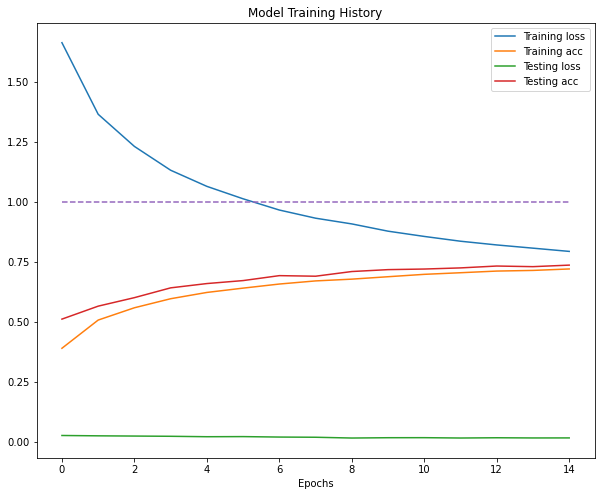

In [27]:
plot_history(cnn2_history)

In [31]:
cnn_model_2.parameters

<bound method Module.parameters of CNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=800, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=800, out_features=10, bias=True)
)>

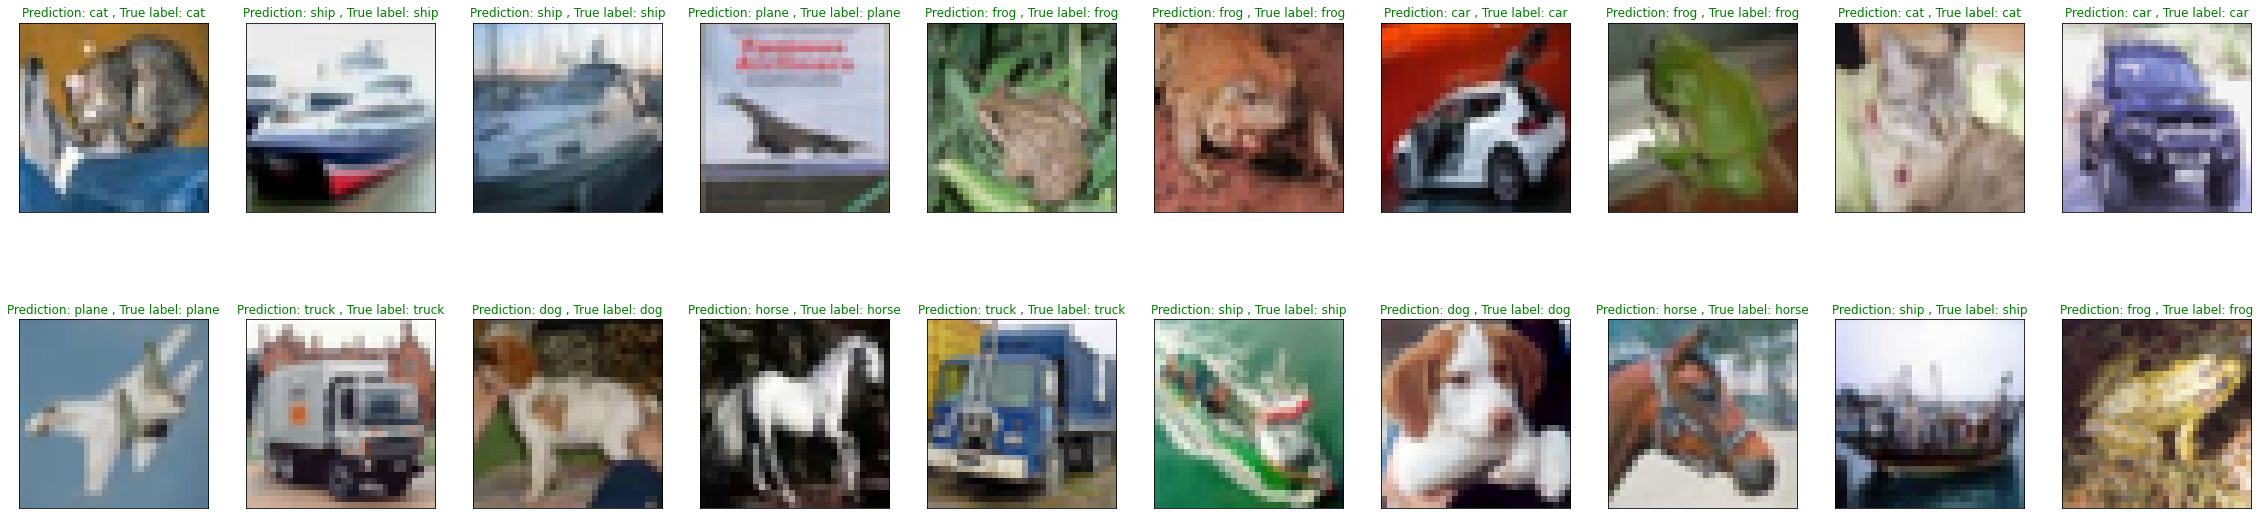

In [28]:
plot_predictions(cnn_model_2)

In [39]:
# preds = []
# true = []

# for test_inputs, test_labels in test_loader:
#     test_inputs = test_inputs.to(mps_device)
#     test_labels = test_labels.to(mps_device)
    
#     true.append(test_labels.cpu().numpy())
    
#     test_outputs = cnn_model_2(test_inputs)
#     _, test_preds = torch.max(test_outputs, 1)
    
#     preds.append(test_preds.cpu().numpy())